In [1]:
import numpy as np
from sklearn.utils import shuffle
import os 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from gensim.models import Word2Vec

In [3]:
os.listdir()

['.DS_Store',
 '.ipynb_checkpoints',
 'cbow_w2v_model',
 'copurchase_count.csv',
 'count_copurchases.ipynb',
 'customer_analysis.ipynb',
 'exploratory_analysis.ipynb',
 'hs_w2v_model',
 'Instacart_product_embeddings.ipynb',
 'order_products__prior.csv',
 'order_products__prior.csv.zip',
 'order_products__train.csv',
 'order_products__train.csv.zip',
 'orders.csv',
 'orders.csv.zip',
 'prior_orders_extended.csv',
 'products.csv',
 'products.csv.zip',
 'shortwindow_w2v_model',
 'Untitled.ipynb',
 'user_product.csv']

### Product metadata

In [4]:
products = pd.read_csv('products.csv')

In [5]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
prod_dict = products.set_index('product_id').T.to_dict()

In [7]:
prod_dict[1]

{'aisle_id': 61,
 'department_id': 19,
 'product_name': 'Chocolate Sandwich Cookies'}

### Orders data

-read in orders and create a list of products per order

In [8]:
lines = open('prior_orders_extended.csv').readlines()

In [9]:
lines[0:4]

['order_id,product_id,add_to_cart_order,reordered,user_id,order_number\n',
 '2539329,196,1,0,1,1\n',
 '2539329,14084,2,0,1,1\n',
 '2539329,12427,3,0,1,1\n']

In [10]:
orders_dict = {}
orders_set = set()
for line in lines[1:]:
    order_i,prod_i,litm_nr,reorder,user_id,user_order_nr = line.strip().split(',')
    if order_i in orders_set:
        orders_dict[order_i].append(prod_i)
    else:
        orders_dict[order_i] = [prod_i]
        orders_set.add(order_i)

In [11]:
orders_dict['2539329']

['196', '14084', '12427', '26088', '26405']

In [12]:
order_prods = list(orders_dict.values())

In [13]:
order_prods[0]

['196', '14084', '12427', '26088', '26405']

In [14]:
len(order_prods)

3214874

In [15]:
basket_size = []
for order in order_prods:
    basket_size.append(len(order))

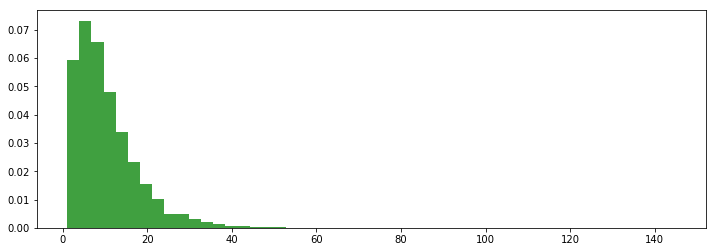

In [16]:
plt.figure(figsize=[12,4])
n, bins, patches = plt.hist(basket_size, 50, normed=1, facecolor='green', alpha=0.75)

In [17]:
print(np.max(basket_size))
print(np.median(basket_size))
print(np.mean(basket_size))

145
8.0
10.088883421247614


### Fit word2vec model

In [18]:
cbow_model = Word2Vec(size=100, window=10, min_count=1, workers=8, sg=0, negative=7)

In [20]:
cbow_model.build_vocab(order_prods)
len(cbow_model.wv.vocab)

49677

In [23]:
%%time
cbow_model.train(shuffle(order_prods),total_examples=cbow_model.corpus_count,epochs=30)

CPU times: user 1h 7min 23s, sys: 1min 9s, total: 1h 8min 32s
Wall time: 23min 56s


935066205

In [24]:
cbow_model.save("cbow_w2v_model")

#### Skipgram, 7 Negative samples, window size 50

In [28]:
w2v_model = Word2Vec(size=100, window=50, min_count=1, workers=8, sg=1, negative=7)

In [29]:
w2v_model.build_vocab(order_prods)
len(w2v_model.wv.vocab)

49677

In [30]:
%%time
w2v_model.train(order_prods,total_examples=w2v_model.corpus_count,epochs=5)

CPU times: user 1h 14min 54s, sys: 35.6 s, total: 1h 15min 29s
Wall time: 19min 56s


155843741

#### Try shorter window size
Because the products are listed in order of add to cart, adjacent products may be more closely related

In [89]:
shortwindow_w2v_model = Word2Vec(size=100, window=5, min_count=1, workers=8, sg=1, negative=7)
shortwindow_w2v_model.build_vocab(order_prods)

In [90]:
%%time
shortwindow_w2v_model.train(order_prods
                            ,total_examples=shortwindow_w2v_model.corpus_count
                            ,epochs=5)

CPU times: user 30min 29s, sys: 9.51 s, total: 30min 38s
Wall time: 8min 7s


155844221

In [147]:
shortwindow_w2v_model.save("shortwindow_w2v_model")

In [58]:
shortwindow_w2v_model = Word2Vec.load("shortwindow_w2v_model")

#### Try hierarchical softmax instead of negative sampling

In [77]:
hs_w2v_model = Word2Vec(size=100, window=5, min_count=1, workers=8, sg=1, hs=1)
hs_w2v_model.build_vocab(order_prods)

In [78]:
%%time
hs_w2v_model.train(order_prods
                    ,total_examples=hs_w2v_model.corpus_count
                    ,epochs=30)

CPU times: user 4h 57min 12s, sys: 1min 12s, total: 4h 58min 25s
Wall time: 1h 18min 51s


935065242

In [97]:
hs_w2v_model.save("hs_w2v_model")

In [43]:
hs_w2v_model = Word2Vec.load("hs_w2v_model")

### Small CBOW model

In [17]:
small_cbow_model = Word2Vec(size=40, window=5, min_count=1, workers=8, sg=0, negative=7)

In [18]:
small_cbow_model.build_vocab(order_prods)
len(small_cbow_model.wv.vocab)

49677

In [19]:
%%time
small_cbow_model.train(shuffle(order_prods)
                       ,total_examples=small_cbow_model.corpus_count,epochs=30)

CPU times: user 44min 31s, sys: 23.8 s, total: 44min 55s
Wall time: 18min 3s


935061610

In [20]:
small_cbow_model.save("small_cbow_model")

### Explore product similarities

In [26]:
def rand_prod(n=1):
    return str(np.random.choice(products['product_id'],n)[0])

In [27]:
def similar_products(query,model):
    print("QUERY:",query,prod_dict[int(query)]['product_name'])
    psim = model.wv.most_similar(query)
    for prod,sim in psim:
        print(sim,prod,prod_dict[int(prod)]['product_name'])

### cat litter

In [87]:
similar_products(rand_prod(),w2v_model)

QUERY: 54 24/7 Performance Cat Litter
0.8294212222099304 970 Salmon and Tuna Formula Dry Cat Food
0.8195797204971313 19368 With Glade Tough Odor Solutions Cat Litter
0.8148465156555176 49355 Instant Action Cat Litter
0.8067525029182434 5889 Crunchy Tuna Flavor Cat Treats
0.8008598685264587 48419 Gourmet Classic Collection Broths
0.7996281385421753 30772 Party Mix Original Flavor Crunch Cat Treats
0.7968029379844666 12905 Adult Indoor Advantage Cat Food
0.7920937538146973 31426 Classic Poultry & Beef Feast Variety Cat Food
0.7916611433029175 20355 Proactive Health Indoor Weight & Hairball Care with Chicken Cat Food
0.7835731506347656 3618 Grilled Seafood Feast Variety Cat Food


In [92]:
similar_products('54',shortwindow_w2v_model)

QUERY: 54 24/7 Performance Cat Litter
0.8091874718666077 31426 Classic Poultry & Beef Feast Variety Cat Food
0.807376503944397 3618 Grilled Seafood Feast Variety Cat Food
0.8033312559127808 45120 One Sensitive Systems Adult Cat Food
0.8026535511016846 49355 Instant Action Cat Litter
0.8022720813751221 24605 Seafood Feast Variety Classic Wet Cat Food
0.8013819456100464 30772 Party Mix Original Flavor Crunch Cat Treats
0.7922881841659546 19368 With Glade Tough Odor Solutions Cat Litter
0.7880860567092896 27793 Elegant Medleys Primavera Collection with Garden Greens Wet Cat Food
0.787569522857666 30018 Prime Filets Turkey Dinner In Gravy
0.7857449054718018 42555 Salmon & Tuna Flavor Cat Food


In [79]:
similar_products('54',hs_w2v_model)

QUERY: 54 24/7 Performance Cat Litter
0.8648022413253784 49355 Instant Action Cat Litter
0.8631085157394409 19368 With Glade Tough Odor Solutions Cat Litter
0.8598500490188599 37520 Indoor Cat Food
0.8433530330657959 3618 Grilled Seafood Feast Variety Cat Food
0.8370373845100403 12905 Adult Indoor Advantage Cat Food
0.8338112831115723 35359 Original Choice Dry Cat Food
0.8302446007728577 31426 Classic Poultry & Beef Feast Variety Cat Food
0.8210101127624512 20355 Proactive Health Indoor Weight & Hairball Care with Chicken Cat Food
0.8179881572723389 28757 Original Cat Chow Naturals Plus Vitamins & Minerals Cat Food
0.7981996536254883 40403 Fancy Feast Seafood Feast Variety Classic Wet Cat Food


In [28]:
similar_products('54',cbow_model)

QUERY: 54 24/7 Performance Cat Litter
0.7704987525939941 49355 Instant Action Cat Litter
0.7483741044998169 3618 Grilled Seafood Feast Variety Cat Food
0.7209925651550293 19368 With Glade Tough Odor Solutions Cat Litter
0.7073407173156738 39161 Florentine Collection Cat Food
0.6912372708320618 970 Salmon and Tuna Formula Dry Cat Food
0.6900243163108826 37520 Indoor Cat Food
0.6831868290901184 31426 Classic Poultry & Beef Feast Variety Cat Food
0.6735385060310364 20355 Proactive Health Indoor Weight & Hairball Care with Chicken Cat Food
0.6713665723800659 28757 Original Cat Chow Naturals Plus Vitamins & Minerals Cat Food
0.6673320531845093 35359 Original Choice Dry Cat Food


#### Sensitive whitening

In [94]:
similar_products('8603',w2v_model)

QUERY: 8603 Sensitive Whitening
0.8084108829498291 8492 Original Regular To Go Unscented Pantiliners
0.8083120584487915 29560 Sleek & Shine Fortifying Shampoo
0.7989720702171326 32322 Shine Anti-Frizz Serum For Frizzy, Dry, Unmanageable Hair
0.7976929545402527 2654 Fusion ProGlide Sensitive 2 in 1 Shave Gel Alpine Clean
0.7973901033401489 31308 Kids Toothbrush Multipack
0.7944557666778564 12737 Soft Full Head Toothbrush
0.7939316034317017 37087 Volume Triple Action Mousse, Maximum Hold
0.7939003705978394 5219 Ninja Turtles Kids Power Toothbrush Extra Soft
0.7933982014656067 819 Totality Multi-Symptom Relief
0.7921473383903503 15027 Cuticle Rehab


In [93]:
similar_products(rand_prod(),shortwindow_w2v_model)

QUERY: 8603 Sensitive Whitening
0.8850874304771423 16000 Deep Clean Body and Face Bar
0.8781979084014893 21816 Daily Pantiliners
0.8757397532463074 24163 Venus Embrace Women's Razor Refills
0.8757051229476929 11349 Ultra Blue Sparkle Liquid Fabric Softener
0.8651639223098755 37960 Extended Moisture Body Lotion
0.8642542362213135 13046 WetJet with Dawn Twin Pack Cleaner Solution Refill
0.8614408373832703 25292 Venus Snap with Embrace Women's Razor with 1 Razor Refill in 1 Compact
0.8612900376319885 43683 Voluminous Original Mascara - Blackest Black 310
0.85877525806427 31220 Outlast Antiperspirant/Deodorant Clear Gel Unscented
0.858672022819519 41310 Original Skin Protectant/Sunscreen SPF 15 Moisturizer


In [81]:
similar_products('8603',hs_w2v_model)

QUERY: 8603 Sensitive Whitening
0.7184264659881592 33392 Ultra Moisture Body Wash With Shea Butter
0.7147479057312012 9656 Triple Clean Mint Floss Picks
0.7084474563598633 3586 Total Whitening Toothpaste
0.7057940363883972 14136 Whitening Plus Scope Crest Complete Whitening + Scope Multi-Benefit Minty Fresh Striped Toothpaste 12.4oz Twin Pack  Dentifrice
0.7051243185997009 16594 Indicator Contour Clean Soft Toothbrush
0.7038821578025818 541 with Dawn Action Pacs Fresh Scent Dishwasher Detergent Pacs
0.6989682912826538 27442 Oil-Free Eye Makeup Remover Cleansing
0.695196807384491 28386 Pearl Plastic Triple Pack Includes Light, Regular, and Super  Unscented Tampons
0.6935348510742188 5696 Soothing Aloe Vera Liquid Hand Soap Refill
0.6900642514228821 20728 Fast Absorbing Body and Face Lotion


In [29]:
similar_products('8603',cbow_model)

QUERY: 8603 Sensitive Whitening
0.738315224647522 28564 UltraClear Invisible Solid Pure Clean Anti-Perspirant & Deodorant
0.7152639627456665 17566 Daily Moisturizing Body Wash
0.7087687253952026 34268 Simply Sensitive Cleansing Wash
0.7084836363792419 45218 Destinations Invisible Solid Paris Romantic Rose Deodorant & Body Spray
0.7015469670295715 1317 Calming Comfort Baby Lotion
0.7003030776977539 30404 Extra Whitening Sensitivity Protection Toothpaste Twin Pack
0.6991150379180908 11349 Ultra Blue Sparkle Liquid Fabric Softener
0.6987699270248413 3586 Total Whitening Toothpaste
0.6966581344604492 37960 Extended Moisture Body Lotion
0.6947885751724243 48324 Maximum Strength Intensive Healing Anti-Itch Crème


#### Worcestershire

In [95]:
similar_products(rand_prod(),w2v_model)

QUERY: 27352 Classic Worcestershire Sauce
0.8056290149688721 18350 Boneless Chuck Roast
0.8011547327041626 15617 Season Bay Leaves Whole .20 Oz
0.7986457347869873 4453 Duck Sauce
0.79637610912323 14367 Cloves
0.7876713871955872 5604 Idaho Potatoes
0.7837342619895935 37813 Hot Madras Curry Powder
0.7829760313034058 17106 Chef's Naturals Pecan Halves
0.7786781787872314 26108 Chilli Powder
0.7758258581161499 30813 99% Fat Free Beef Broth
0.7739967107772827 14972 Square 8 Inch Cake Pans


In [96]:
similar_products('27352',shortwindow_w2v_model)

QUERY: 27352 Classic Worcestershire Sauce
0.8903824687004089 15617 Season Bay Leaves Whole .20 Oz
0.8868159055709839 14507 Original Slaw Dressing
0.8854316473007202 39516 Onion Salt
0.8831251263618469 5604 Idaho Potatoes
0.8820998072624207 3427 All Natural Seasoning Kick'N Chicken
0.8796403408050537 30153 Peeled & De-veined Key West Pink Shrimp
0.8774046897888184 18554 Garlic, Minced
0.8746100664138794 3726 Freeze-Dried Chives
0.872573733329773 26108 Chilli Powder
0.871950626373291 41478 Big Bowl Reusable Containers


In [82]:
similar_products('27352',hs_w2v_model)

QUERY: 27352 Classic Worcestershire Sauce
0.6994431614875793 16890 Slow Cookers Savory Pot Roast Seasoning Mix
0.693492591381073 5604 Idaho Potatoes
0.6647616624832153 4976 Hot Banana Pepper Rings
0.6593236923217773 44398 Fancy Shredded Colby Jack Cheese
0.6495853662490845 19823 Cabbage
0.6490005254745483 1897 Yukon Gold Potatoes Bag
0.6482913494110107 44072 Beef Cooking Stock
0.6423463821411133 14941 Home Style Savory Beef Gravy
0.6422106027603149 41958 Thyme Leaves
0.6416406631469727 3689 Beef Broth


In [30]:
similar_products('27352',cbow_model)

QUERY: 27352 Classic Worcestershire Sauce
0.6668035387992859 3427 All Natural Seasoning Kick'N Chicken
0.660359263420105 21064 Healthy Request Cream of Celery Condensed Soup
0.6577662229537964 1905 Worcestershire Sauce
0.6430639624595642 34630 Beef Eye Round Roast
0.6343475580215454 7472 100% Pure Olive Oil
0.6310278177261353 45258 Parsley Flakes
0.6294339299201965 4976 Hot Banana Pepper Rings
0.6262075901031494 37813 Hot Madras Curry Powder
0.6253413558006287 41062 All Purpose Flour, Bleached
0.6234691143035889 18350 Boneless Chuck Roast


#### grater

In [97]:
similar_products(rand_prod(),w2v_model)

QUERY: 10622 Plastic Frame Grater
0.8708240389823914 13771 Pitted Medium Ripe Olives
0.8605568408966064 17285 Honey Im Strong Conditioner
0.8557800650596619 29002 Deep Roaster Pan
0.851958155632019 44348 Whipped Topping
0.8506990671157837 44846 Confetti Birthday Candle
0.8491764068603516 47821 Yams, Cut Sweet Potatoes in Syrup
0.848597526550293 39573 Egg Noodles
0.845028281211853 45352 Stainless Steel Grater
0.8443853855133057 15854 Thpst P/H Cln Gum Inv Cl
0.8438189029693604 36240 Corer Peeler


In [98]:
similar_products('10622',shortwindow_w2v_model)

QUERY: 10622 Plastic Frame Grater
0.9179924130439758 45352 Stainless Steel Grater
0.916487991809845 35703 Pastry/Basting Brush
0.9130823612213135 22510 Instant Read Thermometer
0.9130620360374451 1949 Amish Blue Cheese Wedge
0.9087669849395752 47483 Masher
0.9081535339355469 30153 Peeled & De-veined Key West Pink Shrimp
0.9033550024032593 33226 Applewood Rub
0.9031089544296265 45758 Cheese, Romano
0.9021131992340088 912 Mushroom Stems & Pieces in Water
0.9019138216972351 17818 3.75 Inches Skewers


In [83]:
similar_products('10622',hs_w2v_model)

QUERY: 10622 Plastic Frame Grater
0.634727418422699 25679 Grated Cheese Parmesan
0.625576376914978 42081 Low Moisture Part Skim Mozzarella Cheese
0.6245229244232178 47518 Finely Shredded Natural Parmesan Cheese
0.6240074634552002 42423 Cheese Shredded Mozzarella Low Moisture Part Skim
0.6215813159942627 9454 Goat Cheese
0.6169717311859131 1541 Jumbo Grade A Eggs
0.6095632910728455 5915 Romano Cheese Wedge
0.6040744781494141 28511 Whipping Cream Ultra Pasteurized
0.599197268486023 1934 Cheese Shredded Mozzarella Reduced Fat 2%
0.5928974747657776 41486 100% Pure Vegetable Oil


In [33]:
similar_products('10622',cbow_model)

QUERY: 10622 Plastic Frame Grater
0.6362559199333191 42081 Low Moisture Part Skim Mozzarella Cheese
0.6201533079147339 17818 3.75 Inches Skewers
0.6060699820518494 31947 Shredded Natural Parmesan-Romano and Asiago Cheese Shaker
0.5988805890083313 29332 Combination Padlock
0.5983797311782837 21354 Turner
0.5978841781616211 29002 Deep Roaster Pan
0.5942680835723877 27556 Eco Foil Poultry Pans
0.5942333936691284 43479 Quart Freezer Reclosable Bags
0.5932685732841492 38645 Five Cheese Pizza Self Rising Crust
0.5930272936820984 5915 Romano Cheese Wedge


In [116]:
similar_products('43716',shortwindow_w2v_model)

QUERY: 43716 Fat Free & Lower Sodium Beef Broth
0.9085972905158997 45214 Seasoning, without Annatto, Econo Pak
0.9029172658920288 35500 Sassy Creamy Horseradish Sauce
0.9012452960014343 36657 Sesame Garlic Sauce & Glaze
0.9006545543670654 28513 Liquid Hand Soap With Aloe Vera
0.8964859247207642 45726 Kosher Whole Wheat Penne Ziti Rigate Pasta
0.8953323364257812 47840 Lightly Dried Chives
0.8944796919822693 41410 Bouillon, Powdered, Chicken Flavored, Econo Pak
0.8913446068763733 33570 American Jazmine Rice
0.890838623046875 16724 Lite Creamy Ranch Dressing + Dip
0.8886902928352356 27518 Spanish Stuffed Queen Olives with Minced Pimientos


In [85]:
similar_products('43716',hs_w2v_model)

QUERY: 43716 Fat Free & Lower Sodium Beef Broth
0.5622630715370178 45883 Egg Noodles Extra Broad
0.5489224195480347 37786 Pure Butter Chocolate Chip Shortbread
0.5468040704727173 20439 All Natural Almond Slices
0.5344844460487366 19823 Cabbage
0.5337159633636475 49381 Zucchini Squash
0.5337097644805908 19917 Complete™ ActionPacs™  Lemon Burst Dishwasher Detergent
0.5229257345199585 10743 Fat Free & Lower Sodium Chicken Broth
0.5199362635612488 48962 Hardwood Smoked Sliced Bacon
0.5139973163604736 45512 Mild Flavor Celery Hearts
0.5136370658874512 45576 Russet Potato Bag


In [32]:
similar_products('43716',cbow_model)

QUERY: 43716 Fat Free & Lower Sodium Beef Broth
0.5856178402900696 32317 Medium Grain Polenta
0.5704953670501709 9306 Noodles, Organic, Udon, Traditional
0.5635271072387695 20805 Pasteurized Crab Meat
0.5311375856399536 45512 Mild Flavor Celery Hearts
0.5278668999671936 3015 Stewed Tomatoes Italian Recipe
0.5263533592224121 10767 Stock-in-a-Box All Natural Chicken Stock
0.5247472524642944 21359 Regular Instant Irish Oatmeal
0.5238707065582275 13903 Baby Peas
0.5209335088729858 11259 2% Low-fat Cottage Cheese
0.5146529078483582 2321 Orange Halo


In [86]:
similar_products('430',hs_w2v_model)

QUERY: 430 Born Yesterday Pale Ale
0.8056119680404663 2083 Lux German Style Lager
0.789583683013916 12527 Sidecar Orange Pale Ale
0.7841295003890991 23335 Piercing Pils
0.7616162300109863 27840 Icelandic White Ale 6 Pack
0.7538843154907227 40987 Citrus Gose Lager
0.7494218349456787 14302 Westfalia Red Ale
0.7482132911682129 31081 Ale, India Pale, Brew Free! Or Die IPA
0.7475150227546692 14725 Obsidian Stout
0.7453224062919617 33448 Strawberry Blonde
0.7424229383468628 960 Villager Ipa


In [145]:
similar_products('430',w2v_model)

QUERY: 430 Born Yesterday Pale Ale
0.9444119930267334 23335 Piercing Pils
0.9359492659568787 2083 Lux German Style Lager
0.9265404343605042 43353 Big Leaf Maple Summer Beer
0.9243641495704651 42120 Grapefruit Radler Can
0.9214556217193604 44469 Kalifornia Kolsch
0.915550708770752 47906 Hefeweizen Beer
0.913158655166626 35910 Porter
0.910198450088501 43615 Black Lager
0.9047936797142029 40506 Pop Gun Pilsner
0.9039969444274902 37819 Otis Oatmeal Stout Beer


In [31]:
similar_products('430',cbow_model)

QUERY: 430 Born Yesterday Pale Ale
0.8405945301055908 14302 Westfalia Red Ale
0.8175256252288818 960 Villager Ipa
0.8024168014526367 27840 Icelandic White Ale 6 Pack
0.7949762344360352 39184 Down To Earth IPA
0.781197190284729 16449 Original Irish Cider
0.7784907817840576 26670 Mighty Dry Hard Cider
0.7745863199234009 4530 Fortunate Islands
0.7730331420898438 34579 Cotes Du Rhone Blanc
0.771461009979248 14974 Ksa Ko?Lsch Style Ale
0.7673152685165405 13581 Pranqster Belgian Style Golden Ale


In [96]:
similar_products(rand_prod(),hs_w2v_model)

QUERY: 600 Thick & Zesty Spaghetti Sauce Mix
0.7580593824386597 2232 Old World Style Meat Flavored Pasta Sauce
0.7475171685218811 8260 Flavored with Meat Italian Sauce
0.7315140962600708 1247 Sloppy Joes Seasoning Mix
0.7252470850944519 43568 Traditional Italian Sauce
0.7063793540000916 1176 Garlic Texas Toast
0.704038679599762 34887 Chunky Tomato Garlic & Onion Pasta Sauce
0.7036259770393372 45290 Thin Spaghetti Pasta
0.6909818649291992 14505 Old World Style Organic Traditional Pasta Sauce
0.6885471940040588 6281 Chunky Garden Combination Pasta Sauce
0.6878663897514343 35372 Italian Sausage and Garlic Meat Sauce
